In [1]:
import pandas as pd
import numpy as np
from feature_selector import FeatureSelector
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import time
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/Users/t.wang/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
/Users/t.wang/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If t

1. The comparison of Wrapper methods involves extracting one year data of one building.
2. The prediction performance is evaluated after implementing various Wrapper methods using metrics such as RMSE.

Caveats:
1. How representitive of that one building out of 482 buildings, can this result (best wrapper method) be applied to all buildings?
2. How aboout repeating this process multiple times? apply the process two all categories, 2-3 buildingds from each category?

In [2]:
features = pd.read_csv('/Users/t.wang/Desktop/Dissertation/Python/WT-result/'+ 'One_year_features' + '.csv')
targets = pd.read_csv('/Users/t.wang/Desktop/Dissertation/Python/WT-result/'+ 'One_year_target' + '.csv')

# Wrapper methods - mlxtend

In [3]:
# As previous plots indicate, score is not improved after 15 features
feature_num = 16
rf_r = RandomForestRegressor(n_estimators=100, random_state=42)

start = time.time()
sfs = SFS(rf_r, 
          k_features=feature_num, 
          forward=True, 
          floating=False, 
          scoring='neg_mean_squared_error',
          cv=4,
          n_jobs=-1)
sfs = sfs.fit(features, targets)
print('\nSequential Forward Selection (k=16):')
print(sfs.k_feature_idx_)
print('CV Score:')
print(sfs.k_score_)
end = time.time()
elapsed = end - start 
print('Time for SFS:'+ time.strftime("%H:%M:%S", time.gmtime(elapsed)))


###################################################
# start = time.time()
# sbs = SFS(rf_r, 
#           k_features=feature_num, 
#           forward=False, 
#           floating=False, 
#           scoring='neg_mean_squared_error',
#           cv=4,
#           n_jobs=-1)
# sbs = sbs.fit(features, targets)
# print('\nSequential Backward Selection (k=16):')
# print(sbs.k_feature_idx_)
# print('CV Score:')
# print(sbs.k_score_)
# end = time.time()
# elapsed = end - start 
# print('Time for SBS:'+ time.strftime("%H:%M:%S", time.gmtime(elapsed)))


###################################################
# The sequential forward floating selection, based on sequential forward selection, has one more verification step.
# The algorithm also verifies the possibility of improvement of the criterion if some feature is excluded. 
# In this case, the worst feature (concerning the criterion) is eliminated from the set, 
# that is, it is performed one step of sequential backward selection (SBS). 
# Therefore, the SFFS proceeds dynamically increasing and decreasing the number of features until the desired d is reached.
# http://www.robots.ox.ac.uk/~teo/campos_icapr2001/node2.html
start = time.time()
sffs = SFS(rf_r, 
          k_features=feature_num, 
          forward=True, 
          floating=True, 
          scoring='neg_mean_squared_error',
          cv=4,
          n_jobs=-1)
sffs = sffs.fit(features, targets)
print('\nSequential Forward Floating Selection (k=16):')
print(sffs.k_feature_idx_)
print('CV Score:')
print(sffs.k_score_)
end = time.time()
elapsed = end - start 
print('Time for SFFS:'+ time.strftime("%H:%M:%S", time.gmtime(elapsed)))


###################################################
# start = time.time()
# sbfs = SFS(rf_r, 
#           k_features=feature_num, 
#           forward=False, 
#           floating=True, 
#           scoring='neg_mean_squared_error',
#           cv=4,
#           n_jobs=-1)
# sbfs = sbfs.fit(features, targets)
# print('\nSequential Backward Floating Selection (k=16):')
# print(sbfs.k_feature_idx_)
# print('CV Score:')
# print(sbfs.k_score_)
# end = time.time()
# elapsed = end - start 
# print('Time for SBFS:'+ time.strftime("%H:%M:%S", time.gmtime(elapsed)))


Sequential Forward Selection (k=16):
(2, 6, 8, 11, 53, 64, 66, 68, 75, 83, 95, 96, 102, 113, 116, 126)
CV Score:
-672.4211560709999
Time for SFS:00:53:13

Sequential Forward Floating Selection (k=16):
(2, 6, 11, 22, 23, 44, 49, 53, 63, 64, 66, 86, 92, 95, 105, 106)
CV Score:
-661.3537350972724
Time for SFFS:01:59:13


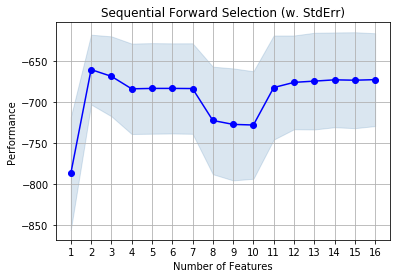

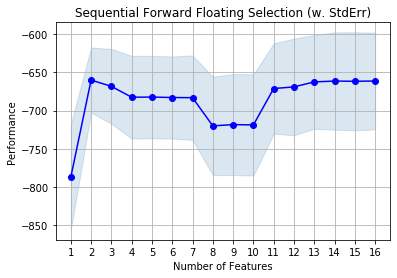

In [5]:
# Plotting the results
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()


# Plotting the results
fig = plot_sfs(sffs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Floating Selection (w. StdErr)')
plt.grid()
plt.show()

In [6]:
# new features after SFS
features_SFS = sfs.transform(features)
features_SFS.shape

(8760, 16)

In [7]:
# new features after SFFS
features_SFFS = sffs.transform(features)
features_SFFS.shape

(8760, 16)

# Wrapper method - SKlearn

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE

In [9]:
features.shape

(8760, 128)

In [11]:
# Recursive feature elimination 
start = time.time()
rfe = RFE(estimator=rf_r, step=8,verbose=True)
rfe = rfe.fit(features, targets)
end = time.time()
elapsed = end - start 
print('Time for RFE:'+ time.strftime("%H:%M:%S", time.gmtime(elapsed)))

Fitting estimator with 128 features.
Fitting estimator with 120 features.
Fitting estimator with 112 features.
Fitting estimator with 104 features.
Fitting estimator with 96 features.
Fitting estimator with 88 features.
Fitting estimator with 80 features.
Fitting estimator with 72 features.
Time for RFE:00:06:18


In [12]:
features_RFE = rfe.transform(features)
features_RFE.shape

(8760, 64)

In [15]:
start = time.time()
# cross validation after RFE, cv=4 and scoring='neg_mean_squared_error', same as mlxtend
RFE_Score = cross_val_score(rf_r, features_RFE, targets, cv=4, scoring='neg_mean_squared_error',n_jobs=-1)
# fix the sign of MSE scores
mse_RFE_Score = -RFE_Score
# convert from MSE to RMSE 
rmse_RFE_Score = np.sqrt(mse_RFE_Score)
# calculate the average RMSE
end = time.time()
elapsed = end - start 
print('Time for RFE_CV:'+ time.strftime("%H:%M:%S", time.gmtime(elapsed)))
print(rmse_RFE_Score.mean())

Time for RFE_CV:00:00:26
26.36783995519145


In [16]:
print('rmse_SFS_Score:')
print(np.sqrt(-sfs.k_score_))

rmse_SFS_Score:
25.931084745359186


In [17]:
print('rmse_SFFS_Score:')
print(np.sqrt(-sffs.k_score_))

rmse_SFFS_Score:
25.71679869457457


In [ ]:
# scoring metrics: https://scikit-learn.org/stable/modules/model_evaluation.html

1. The SFFS shows no obvious advantages over SFS, but takes twice the time
2. SFS takes 1h and SFFS takes 2hs, due to the fact that SFFS introduces one more conditinal exclusion step
3. The time spent on SFS and SFFS algorithms primarily depends on how much features are wanted, 16 in this case
4. If the number of wanted features outnumbered half of the total features, use SBS, otherwise SFS
5. SKlearn - RFE is computationally less complex, feature number does not need to be specified, the time is primarily associated with steps
6. Regarding the accuracy, RFE is slightly inferior, which is eclipsed by the the advantage of computational cost saving
7. Therefore, RFE could be a good option for further analysis
8. Caveats: the hyperparameter is not detailly comparable, such as the 'number of features' in SFSs and 'steps' in REF
9. We need again consider the selection of 'steps' in REF and how to reduce the computational cost, 7min is still too slow, potentially think about reduce the dimensions further with the aid of Filter method. Look at something in PCA